PlotBot
In this activity, more challenging than the last, you will build a Twitter bot that sends out visualized sentiment analysis of a Twitter account's recent tweets.

Visit https://twitter.com/PlotBot5 for an example of what your script should do.

The bot receives tweets via mentions and in turn performs sentiment analysis on the most recent twitter account specified in the mention

For example, when a user tweets, "@PlotBot Analyze: @CNN," it will trigger a sentiment analysis on the CNN twitter feed.

A plot from the sentiment analysis is then tweeted to the PlotBot5 twitter feed. See below for examples of scatter plots you will generate:

@juanitasoranno.png@nancypwong.pngnytimes.png

Hints, requirements, and considerations:


* Your bot should scan your account every five minutes for mentions.
* Your bot should pull 500 most recent tweets to analyze for each incoming request.
* Your script should prevent abuse by analyzing only Twitter accounts that have not previously been analyzed.
* Your plot should include meaningful legend and labels.
It should also mention the Twitter account name of the requesting user.
When submitting your assignment, be sure to have at least three analyses tweeted out from your account (enlist the help of classmates, friends, or family, if necessary!).
Notable libraries used to complete this application include: Matplotlib, Pandas, Tweepy, TextBlob, and Seaborn.
You may find it helpful to organize your code in function(s), then call them.
If you're not yet familiar with creating functions in Python, here is a tutorial you may wish to consult: https://www.tutorialspoint.com/python/python_functions.htm.

In [52]:
#Plot Bot

# Dependencies
import tweepy
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import json

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Setup Tweepy API Authentication
from config import (consumer_key, consumer_secret, access_token, access_token_secret)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [53]:
def vader_tweet(tweet):
    '''returns vader polarity scores with the addition of a overall polarity score'''

    results = analyzer.polarity_scores(tweet)
    return results

In [54]:
vader_tweet('Sadness and joy')

{'compound': 0.2263, 'neg': 0.377, 'neu': 0.13, 'pos': 0.494}

In [55]:
def tweet_sentiments(user):

    # Counter
    counter = 1

    # Variables for holding sentiments
    sentiments = []

    # Loop through 25 pages of tweets (total 100 tweets)
    for x in range(5):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(user)

        # Loop through all tweets 
        for tweet in public_tweets:
            print("Analyzing tweet: \n")
            print("---" * 30)
            pprint(tweet['text'])
            
            # Run Vader Analysis on each tweet
            results = vader_tweet(tweet['text'])
            tweets_ago = counter
            sentiments.append(results)
            # Add to counter 
            counter = counter + 1
    polarities = list()
    positivity_list = list()
    negativity_list = list()
    for record in sentiments:
        polarities.append(record['compound'])
        positivity_list.append(record['pos'])
        negativity_list.append(record['neg'])
    
    final_json = json.dumps({ "user":user, 
                              "polarity":polarities,
                              "neg":negativity_list,
                              "pos":positivity_list
                            })
    df = pd.read_json(final_json)
    return df
    
    
    
    

In [56]:
sentiments = tweet_sentiments("@co_cothoughts")

Analyzing tweet: 

------------------------------------------------------------------------------------------
'@MoodPlot analyze @co_cothoughts'
Analyzing tweet: 

------------------------------------------------------------------------------------------
'@Moodplot plot analysis for @co_cothoughts'
Analyzing tweet: 

------------------------------------------------------------------------------------------
'Weather in Irivne at 07:32 PM: light rain, 63.25 F'
Analyzing tweet: 

------------------------------------------------------------------------------------------
'Happiness is a warm puppy. - Charles M. Schulz'
Analyzing tweet: 

------------------------------------------------------------------------------------------
('Count your age by friends, not years. Count your life by smiles, not tears. '
 '- John Lennon')
Analyzing tweet: 

------------------------------------------------------------------------------------------
('For every minute you are angry you lose sixty seconds of h

Analyzing tweet: 

------------------------------------------------------------------------------------------
'@MoodPlot analyze @co_cothoughts'
Analyzing tweet: 

------------------------------------------------------------------------------------------
'@Moodplot plot analysis for @co_cothoughts'
Analyzing tweet: 

------------------------------------------------------------------------------------------
'Weather in Irivne at 07:32 PM: light rain, 63.25 F'
Analyzing tweet: 

------------------------------------------------------------------------------------------
'Happiness is a warm puppy. - Charles M. Schulz'
Analyzing tweet: 

------------------------------------------------------------------------------------------
('Count your age by friends, not years. Count your life by smiles, not tears. '
 '- John Lennon')
Analyzing tweet: 

------------------------------------------------------------------------------------------
('For every minute you are angry you lose sixty seconds of h

Analyzing tweet: 

------------------------------------------------------------------------------------------
'@MoodPlot analyze @co_cothoughts'
Analyzing tweet: 

------------------------------------------------------------------------------------------
'@Moodplot plot analysis for @co_cothoughts'
Analyzing tweet: 

------------------------------------------------------------------------------------------
'Weather in Irivne at 07:32 PM: light rain, 63.25 F'
Analyzing tweet: 

------------------------------------------------------------------------------------------
'Happiness is a warm puppy. - Charles M. Schulz'
Analyzing tweet: 

------------------------------------------------------------------------------------------
('Count your age by friends, not years. Count your life by smiles, not tears. '
 '- John Lennon')
Analyzing tweet: 

------------------------------------------------------------------------------------------
('For every minute you are angry you lose sixty seconds of h

In [57]:
sentiments.head()
sentiments['neg'].values
sentiments['user'][0]

'@co_cothoughts'

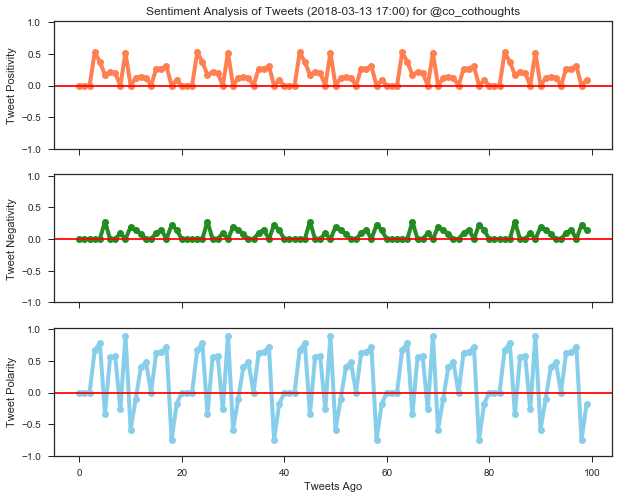

In [59]:
def tweet_plot(sentiments, user):
    
    #plot out polarities positive and negative
    plt.rcParams["figure.figsize"] = (10,8)
    
    pos = sentiments.pos.values
    neg = sentiments.neg.values
    polarity = sentiments.polarity.values
    
    ymax = max(np.append(pos, neg)) + .5
   
    
    f, (ax1,ax2, ax3) = plt.subplots(3, 1, sharey=True, sharex=True)
    ax1.set_ylim(ymax=ymax, ymin=-1)
    x_axis = np.arange(0,len(sentiments))
    #sns.kdeplot(sentiments.pos.values, shade=True, color="forestgreen", ax=ax1)
    #sns.kdeplot(sentiments.neg.values,shade=True, color='coral',  ax=ax2)
    ax1.plot(x_axis, pos, '-', color='coral', linewidth=4, marker="o")
    ax2.plot(x_axis, neg, '-', color='forestgreen', linewidth=4, marker="o")
    ax3.plot(x_axis, polarity, '-', color='skyblue', linewidth=4, marker="o")
    #  Incorporate the other graph properties
    now = datetime.now()
    now = now.strftime("%Y-%m-%d %H:%M")
    ax1.set_title("Sentiment Analysis of Tweets ({}) for {}".format(now, user))
    
    #draw horizontal line that seperates positive and negative values
    ax1.axhline(y=0, xmin=0, xmax=max(x_axis),color="red")
    ax2.axhline(y=0, xmin=0, xmax=max(x_axis),color="red")
    ax3.axhline(y=0, xmin=0, xmax=max(x_axis),color="red")
    #labels
    ax3.set_ylabel("Tweet Polarity")
    ax2.set_ylabel("Tweet Negativity")
    ax1.set_ylabel("Tweet Positivity")
    ax3.set_xlabel("Tweets Ago")
    plt.show()
tweet_plot(sentiments, sentiments['user'][0])    

In [61]:

def mention_check():
    ''' activates when a twitter user tweets @plotmood and then returns a graph of polarities'''
    
    # Target Term
    target_term = "@MoodPlot"

    # Get the last 10 tweets
    public_tweets = api.search(target_term, count=10, result_type="recent", since_id=None)

    # Loop through all public_tweets
    for tweet in public_tweets["statuses"]:

        # Get ID and Author of most recent tweet
        tweet_id = tweet["id"]
        tweet_author = tweet["user"]["screen_name"]
        tweet_text = tweet["text"]
        user_mentions = set()
        for user in tweet['entities']['user_mentions']:
            user_mentions.add(user['screen_name'])
        

        # Print Tweet Text and Tweet Author
        print(tweet_id)
        print(tweet_text)
        print("Tweet Author: ", tweet_author)
        print("user mentions", user_mentions)

    #gather last ten tweets 
    

    # Print success message
    print("checked successfully, sir!")
    return user_mentions
mention_check()

973025188634804224
@MoodPlot analyze @co_cothoughts
Tweet Author:  co_cothoughts
user mentions {'MoodPlot', 'co_cothoughts'}
973022735860252672
@Moodplot plot analysis for @co_cothoughts
Tweet Author:  co_cothoughts
user mentions {'MoodPlot', 'co_cothoughts'}
checked successfully, sir!


{'MoodPlot', 'co_cothoughts'}

In [69]:
mentions = mention_check()

if str('MoodPlot') in list(mentions):
    print("Activating Twitter bot")
    mentions.remove('Moodplot')
    
else:
    print('nothing to tweet')

973025188634804224
@MoodPlot analyze @co_cothoughts
Tweet Author:  co_cothoughts
user mentions {'MoodPlot', 'co_cothoughts'}
973022735860252672
@Moodplot plot analysis for @co_cothoughts
Tweet Author:  co_cothoughts
user mentions {'MoodPlot', 'co_cothoughts'}
checked successfully, sir!
Activating Twitter bot


In [ ]:
# Set timer to run 5 minutes every hour
t_end = time.time() + 3600 * 24
while(time.time() < t_end):
    #wait thirty seconds before sending out tweet    
    time.sleep(30)